In [1]:
# Import the libraries
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
from odc.stac import configure_rio, stac_load
import dask.distributed
import dask.utils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# Set up Dask client for parallel processing
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)

# Configure rio with dynamic resolution
resolution = 20
memory_limit = dask.utils.parse_bytes(client.cluster.workers[0].memory_manager.memory_limit)
SHRINK = 4
if memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # Adjust chunk size if memory is limited

resolution = resolution * SHRINK


In [ ]:
# Define the area of interest (AOI) for Lake Michigan
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-88.2, 43.0],  # Lower-left corner
            [-86.1, 43.0],  # Lower-right corner
            [-86.1, 45.0],  # Upper-right corner
            [-88.2, 45.0],  # Upper-left corner
            [-88.2, 43.0],  # Closing the polygon
        ]
    ],
}

#  time span of 3 months
time_of_interest = "2023-06-01/2023-09-01"

# Query the catalog for the data
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest
)
items = list(search.items())
print(f"Returned {len(items)} Items")


Returned 317 Items


In [4]:
# Load the data from the catalog with dynamic chunking and handle missing data
xx = stac_load(
    items,
    chunks={"x": 1024 * SHRINK, "y": 1024 * SHRINK},  # Dynamically adjust chunk size
    patch_url=planetary_computer.sign,
    resolution=resolution,
    dtype="uint16",  # Handle missing data by marking nodata values
    nodata=0
)

# Display loaded data
print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)


Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset> Size: 6GB
Dimensions:      (y: 1938, x: 1937, time: 54)
Coordinates:
  * y            (y) float64 16kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 15kB 3.001e+05 3.002e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 432B 2023-06-01T16:28:39.024000 ... 20...
Data variables: (12/16)
    AOT          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B01          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B02          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B03          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B04          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B05          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B12          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B8A          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    SCL          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    WVP          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    visual       (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>

In [5]:
# Function to convert data to float and handle missing nodata values
def to_float(xx, nodata_value=None):
    _xx = xx.astype("float32")  # Convert data to float32 for precision
    if nodata_value is None:
        nodata_value = _xx.attrs.pop("nodata", None)  # Fetch nodata value if exists
    if nodata_value is not None:
        return _xx.where(xx != nodata_value)  # Replace nodata with NaN
    return _xx

# Convert specific bands to float32 and handle missing data
b05 = to_float(xx.B05)  # Red-Edge band
b04 = to_float(xx.B04)  # Red band


In [6]:
# Calculate NDCI with small constant to avoid division by zero
ndci = (b05 - b04) / (b05 + b04 + 1e-6)

# Display the calculated NDCI
display(ndci)

<xarray.DataArray (time: 54, y: 1938, x: 1937)> Size: 811MB
dask.array<truediv, shape=(54, 1938, 1937), dtype=float32, chunksize=(1, 1938, 1937), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 16kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 15kB 3.001e+05 3.002e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 432B 2023-06-01T16:28:39.024000 ... 20...

In [7]:
ndci = ndci.fillna(ndci.mean())

In [8]:
chl = 826.57*(ndci**3) - 176.43*(ndci**2) + 19*(ndci) + 4.071
display(chl)

<xarray.DataArray (time: 54, y: 1938, x: 1937)> Size: 811MB
dask.array<add, shape=(54, 1938, 1937), dtype=float32, chunksize=(1, 1938, 1937), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 16kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 15kB 3.001e+05 3.002e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 432B 2023-06-01T16:28:39.024000 ... 20...

In [9]:
# Select a subset of coordinates (first 100 coordinates)
chl_subset = chl[:, :5, :5]

In [10]:
print(chl_subset.shape)

(54, 5, 5)


In [11]:
# Define a function to prepare the time series data for LSTM
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Set time steps (e.g., using last 5 values to predict the next)
time_steps = 10
#forecast_horizon = 5  # How many future timesteps to predict
X, y = create_dataset(chl_subset, time_steps)
print(f"X shape: {X.shape}, y shape: {y.shape}")



/Users/aryamaniboruah/Desktop/Untitled/.venv/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/Users/aryamaniboruah/Desktop/Untitled/.venv/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/Users/aryamaniboruah/Desktop/Untitled/.venv/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
2024-12-05 18:30:58,997 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:55726 -> tcp://127.0.0.1:55717
Traceback (most recent call last):
  File "/Users/aryamaniboruah/Desktop/Untitled/.venv/lib/python3.10/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd

X shape: (44, 10, 5, 5), y shape: (44, 5, 5)


In [12]:
print(X)

[[[[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
   [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
   [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
   [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
   [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]]

  [[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
   [ 5.096548   4.705545   4.833828   4.7148046  4.734061 ]
   [ 4.7716393  4.8343954  4.8126745  4.792401   4.87009  ]
   [ 4.801095   4.657792   4.6615887  4.8458204  4.7578783]
   [ 4.7471666  4.784837   4.855433   4.7681007  4.889628 ]]

  [[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
   [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
   [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
   [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
   [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]]

  ...

  [[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
   [ 4.51752    4.5613375  

In [13]:
print(y)

[[[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]]

 [[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]]

 [[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [10.881298   9.421568   9.99906    7.879238   7.2736464]
  [ 5.1276045  5.4777403  9.051678   7.771348   6.479797 ]
  [ 4.993699   5.413669   5.3500257  8.669097   6.9853578]
  [ 5.0486517  5.092511   5.6235523  8.302427   5.8084583]]

 ...

 [[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.83874

In [14]:
# Reshape the input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], chl_subset.shape[1] * chl_subset.shape[2]))
y = np.reshape(y, (y.shape[0], chl_subset.shape[1] * chl_subset.shape[2]))

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (44, 10, 25), y shape: (44, 25)


In [15]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (35, 10, 25), y_train shape: (35, 25)
X_test shape: (9, 10, 25), y_test shape: (9, 25)


In [16]:
from sklearn.preprocessing import MinMaxScaler
# Normalize input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)

X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

# Normalize target variable
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape back to the original shape
y_train_scaled = y_train_scaled.reshape(y_train.shape)  
y_test_scaled = y_test_scaled.reshape(y_test.shape) 

In [17]:
print(X_train_scaled.shape, y_train_scaled.shape)

(35, 10, 25) (35, 25)


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(y.shape[1], activation='linear')
])
# Output a single value for each spatial location (the predicted next time point)
model.compile(optimizer='adam', loss='mean_squared_error')


# Print the model summary
model.summary()

/Users/aryamaniboruah/Desktop/Untitled/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,675 (143.26 KB)

 Trainable params: 36,675 (143.26 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
print(X_train.shape)
print(y_train.shape)
# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=5, batch_size=32, validation_split=0.2)

(35, 10, 25)
(35, 25)
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0129 - val_loss: 0.0117
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0090 - val_loss: 0.0099
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0068 - val_loss: 0.0091
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0061 - val_loss: 0.0089
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0060 - val_loss: 0.0088


In [20]:
# Evaluate the model
results = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Model loss (MSE): {results}")
print("RMSE: ", np.sqrt(results))

# Make predictions
predictions = model.predict(X_test_scaled)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Model loss (MSE): 0.002771139144897461
RMSE:  0.05264161039422579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
[[ 1.63557325e-02  1.78502332e-02 -2.34730225e-02 -3.00285080e-03
   8.01423565e-03  5.49191162e-02  4.44342308e-02  1.26256868e-02
   5.11189140e-02  9.96030495e-03  5.90281971e-02  3.84140089e-02
   3.03602405e-02  1.28346011e-02  5.14488854e-03 -1.99127011e-04
   2.06569023e-02  4.85578477e-02 -4.29931469e-02  2.43301429e-02
  -2.01525260e-02  1.68599077e-02  4.59154416e-03  4.31665108e-02
  -4.07785736e-03]
 [ 3.57070193e-02 -1.09146163e-02 -1.61930732e-02 -4.76559717e-03
   7.92443566e-03  3.40839513e-02  5.37359938e-02  2.45551448e-02
   3.05557363e-02  2.22704504e-02  6.05671853e-02  3.50678936e-02
   3.59617099e-02  4.73000072e-02 -8.16619582e-03  1.30720274e-03
   1.60028152e-02  5.04161827e-02 -2.69201063e-02  1.67430062e-02
  -9.56898369e-03  2.19853632e-02  6.80425530e-03  3.17328237e-02
  -8.43486935e-03]
 [ 3.76548097

In [21]:
print(predictions.shape)

(9, 25)


In [22]:
print(y_test_scaled.min(), y_test_scaled.max())

0.007176459 0.43939108


In [23]:
print(predictions.min(), predictions.max())

-0.047883905 0.07114037


In [24]:
y_pred = scaler_y.inverse_transform(predictions.reshape(-1, 1))

# Reshape the predictions back to the original shape
y_pred = y_pred.reshape(y_test.shape)

In [25]:
print(y_pred.min(), y_pred.max())

3.175346 5.758468


In [26]:
print(y_pred.shape)

(9, 25)


In [27]:
print(y_pred)
print(y_test)

[[4.569506  4.60194   3.705123  4.1493764 4.3884745 5.406427  5.1788793
  4.4885545 5.323953  4.4307094 5.495604  5.0482254 4.8734384 4.4930882
  4.326203  4.210224  4.662852  5.2683716 3.281488  4.7425704 3.777186
  4.5804477 4.3141937 5.151366  4.126046 ]
 [4.9894767 3.9776716 3.8631158 4.1111207 4.3865256 4.9542522 5.38075
  4.7474537 4.8776813 4.6978703 5.529004  4.9756064 4.995004  5.2410736
  4.037319  4.2429156 4.5618467 5.3087025 3.6303127 4.5779104 4.006875
  4.691683  4.362215  4.903227  4.031488 ]
 [5.031749  3.9170182 3.7697277 4.163392  4.39483   5.0088162 5.4414244
  4.801593  4.9169407 4.7287936 5.714807  5.006678  5.035394  5.196859
  4.143572  4.214802  4.5063214 5.3122697 3.4867923 4.6327405 3.988517
  4.6730857 4.2835064 5.053049  4.115438 ]
 [4.5223403 4.634593  3.709673  4.1603513 4.3830214 5.4417534 5.1634693
  4.4740005 5.3353944 4.38315   5.4458346 5.049626  4.870408  4.473565
  4.2955217 4.217047  4.7022376 5.271698  3.295761  4.724177  3.7643285
  4.585079  4.

In [ ]:
# import numpy as np

# # Save predictions as a Numpy .npy file
# np.save("predictions.npy", y_pred)
# np.save("y_test.npy", y_test)

In [28]:
# Reshape y_test_inverse back to its original shape
y_test_inverse = y_test.reshape((y_test.shape[0], chl_subset.shape[1], chl_subset.shape[2]))
print(y_test_inverse)

[[[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 5.820029   5.6979504  5.715619   5.7531576  5.759344 ]
  [ 5.776979   5.7610188  5.689459   5.7697067  5.7553043]
  [ 5.7914     5.7508016  5.840335   5.7847056  5.7816124]
  [ 5.750583   5.8150253  5.780084   5.813018   5.8097377]]

 [[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]]

 [[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 6.792327   6.710152   5.5620747  5.4915247  5.348043 ]
  [ 5.0602617  4.9084983  5.724551   5.305843   5.426046 ]
  [ 5.033969   4.833434   4.8534994  5.5510216  6.0176506]
  [ 4.9114947  4.8689594  4.953043   5.73562    5.061224 ]]

 [[ 4.8387403  4.8387403  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403  4.8387403  4.

In [29]:
print(y_test_inverse.shape)

(9, 5, 5)


In [30]:
# Reshape y_test_inverse back to its original shape
y_pred_inverse = y_pred.reshape((y_pred.shape[0], chl_subset.shape[1], chl_subset.shape[2]))
print(y_pred_inverse.shape)

(9, 5, 5)


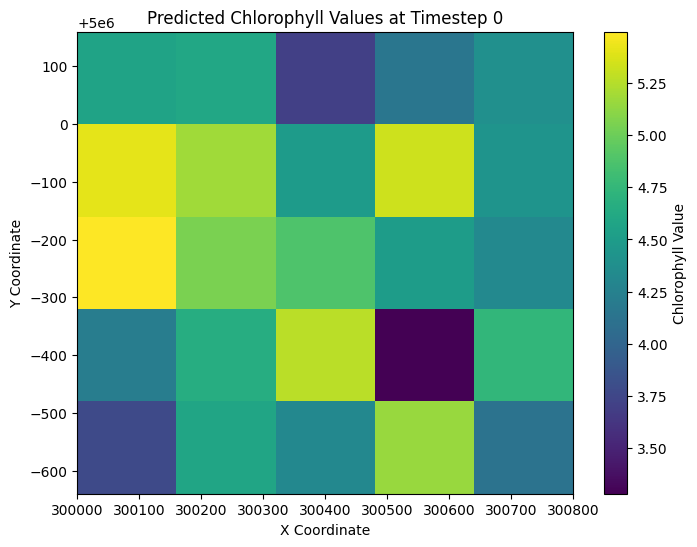

In [31]:
# Select a timestep to visualize (e.g., the first timestep in the test set)
timestep = 0

# Extract the data for the selected timestep
y_pred_timestep = y_pred_inverse[timestep]

# Extract the actual coordinates
x_coords = chl_subset.coords['x'].values
y_coords = chl_subset.coords['y'].values

# Create the visualization
plt.figure(figsize=(8, 6))
plt.pcolormesh(x_coords, y_coords, y_pred_timestep, cmap='viridis', shading='auto')
plt.colorbar(label='Chlorophyll Value')
plt.title(f'Predicted Chlorophyll Values at Timestep {timestep}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

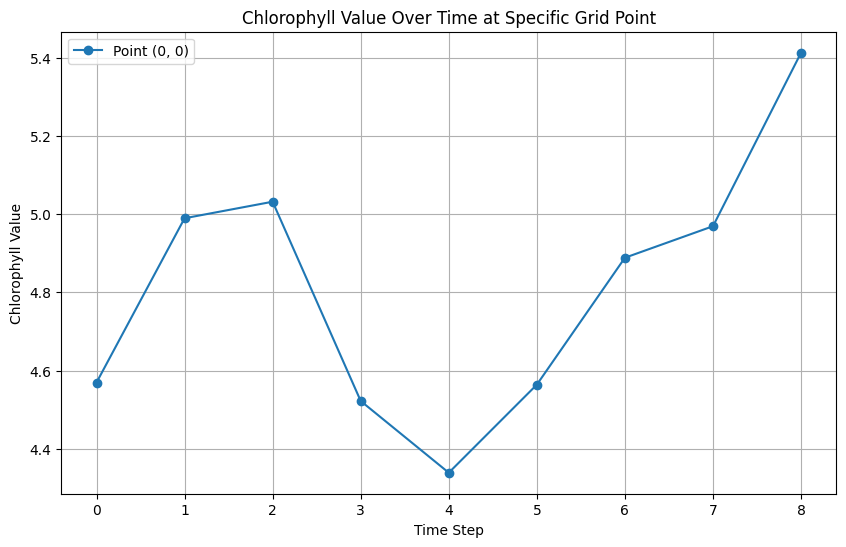

In [32]:
# Select a specific grid point (e.g., x_idx = 0, y_idx = 0 for top-left corner)
x_idx, y_idx = 0, 0

# Extract chlorophyll values over time for the specific point
time_series = y_pred_inverse[:, y_idx, x_idx]

# Plot chlorophyll values over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(time_series)), time_series, marker='o', linestyle='-', label=f'Point ({x_idx}, {y_idx})')
plt.title('Chlorophyll Value Over Time at Specific Grid Point')
plt.xlabel('Time Step')
plt.ylabel('Chlorophyll Value')
plt.grid()
plt.legend()
plt.show()


In [33]:
model.save('LSTM_model.h5')
print("Model saved to LSTM_model.h5")

Model saved to LSTM_model.h5
